<a href="https://colab.research.google.com/github/Anoushehm/intro-ml-course-winter2026/blob/main/ML_project_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HAD5016 - Project - Phase #2 - High-fidelity
**Project:** This colab file aims to answer the following research questions:

1.   To evaluate the independent predictive capacity of four distinct clinical domains (chronic diseases, physiological biomarkers, major health events, and medication exposures) for the diagnosis of depression and anxiety among Ontario adults.
2.   To investigate the comparative performance and potential synergistic effects of these feature sets when utilized in isolation versus in various integrated combinations.
3.    To determine whether the optimal set of predictors remains consistent across different diagnostic definitions, specifically comparing individual diagnoses of depression or anxiety against a composite psychiatric outcome.


 **Data:** answer to this question, we will use the the Canadian Primary Care Sentinel Surveillance Network (CPCSSN)1, which contains line-level clinical data collected in primary care settings across Ontario. The study population includes individuals aged 18 years and older.


**Programmer:** Anousheh, Valeria

**Team Number:** 7


**Date started:** February 20th, 2026

**Last update:** February 26th, 2026

# Table of Content


1.   Setup
2.   Import and explore data
3.   Reorganize data for longitudinal analysis
4.   Define cohort and depression outcome properly
5.   Random Forest and Evaluation



# 0. Setup

In [1]:
# Import libraries we need
!pip install category_encoders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

#warnings.filterwarnings('ignore')

# 1. Import and explore the data

In [2]:
# Import data from Google Drive
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/HAD5016-Project/TMU_DM_808K_R1.csv'
cpc_RAW = pd.read_csv(file_path)

# View the first few rows of the dataset
cpc_RAW.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-58691/3588437385.py:5: DtypeWarning: Columns (28,29,31,33,35,37,39,41,43,47,49,51,55,57,59,61,63,65,67,69,71,77,79,81,83,85,87,91,93,95,97,101,103,105,107,109,136,137,139,140,145,148,153,156,161,163,164,168,169,171,172) have mixed types. Specify dtype option on import or set low_memory=False.
  cpc_RAW = pd.read_csv(file_path)


,Age_at_Exam,Sex,sBP,sBP_Date,BMI,BMI_Date,LDL,LDL_Date,HDL,HDL_Date,...,duration_b_R1_[corticosteroid]_Days,total_b_R1_[corticosteroid]_Records,first_b_R1_[1stlineantidiabetic],first_StartDate_b_R1_[1stlineantidiabetic],first_StopDate_b_R1_[1stlineantidiabetic],last_b_R1_[1stlineantidiabetic],last_StartDate_b_R1_[1stlineantidiabetic],last_StopDate_b_R1_[1stlineantidiabetic],duration_b_R1_[1stlineantidiabetic]_Days,total_b_R1_[1stlineantidiabetic]_Records
0,69,Male,140.0,2010-03-18,26.000000,2010-12-17,3.35,2010-03-06,1.03,2010-03-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,56,Female,120.0,2011-11-03,24.000000,2011-11-03,4.01,2011-10-04,1.84,2011-10-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,35,Female,100.0,2014-02-21,51.195667,2014-02-21,3.11,2014-02-24,1.26,2014-02-24,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,43,Female,138.0,2013-07-04,67.794421,2013-07-04,2.96,2013-08-02,1.09,2013-08-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,49,Male,141.0,2013-03-13,34.000000,2013-01-24,4.06,2013-01-24,1.34,2013-01-24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Number of observations: 808921
Number of duplicated observations: 63452
Percentage of duplicated rows: 7.84%
['Age_at_Exam', 'Sex', 'sBP', 'sBP_Date', 'BMI', 'BMI_Date', 'LDL', 'LDL_Date', 'HDL', 'HDL_Date', 'A1c', 'A1c_Date', 'TG', 'TG_Date', 'FBS', 'FBS_Date', 'Total_Cholesterol', 'Total_Cholesterol_Lab_Date', 'Diabetes', 'Depression', 'Depression_OnsetDate', 'HTN', 'HTN_OnsetDate', 'OA', 'OA_OnsetDate', 'COPD', 'COPD_Date', 'Patient_ID', 'DM_OnsetDate', 'DM_Onset_Revised_1YrPrior', '[Amputation)', '[Amputation_Date]', '[Anxiety)', '[Anxiety_Date]', '[Arrhythmia)', '[Arrhythmia_Date]', '[AtrialFibrillation)', '[AtrialFibrillation_Date]', '[Blindness)', '[Blindness_Date]', '[CABG)', '[CABG_Date]', '[CAD)', '[CAD_Date]', '[Cancer)', '[Cancer_Date]', '[Cardiomyopathy)', '[Cardiomyopathy_Date]', '[Cataract)', '[Cataract_Date]', '[CKD)', '[CKD_Date]', '[Deceased)', '[Deceased_Date]', '[Depression)', '[Depression_Date]', '[DiabeticFootUlcer)', '[DiabeticFootUlcer_Date]', '[Dialysis)', '[Di

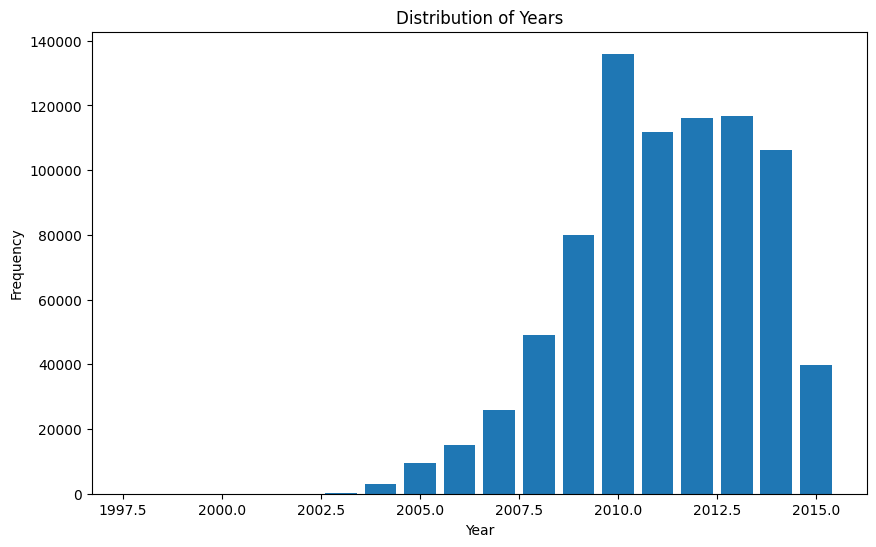

Number of unique patients: 171619


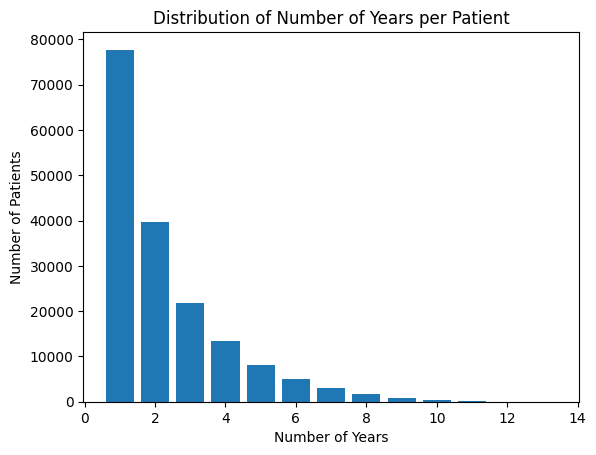

Number of patients with multiple records: 93905
Percentage of patients with multiple records: 54.72%
Average number of visits per patient: 4.71


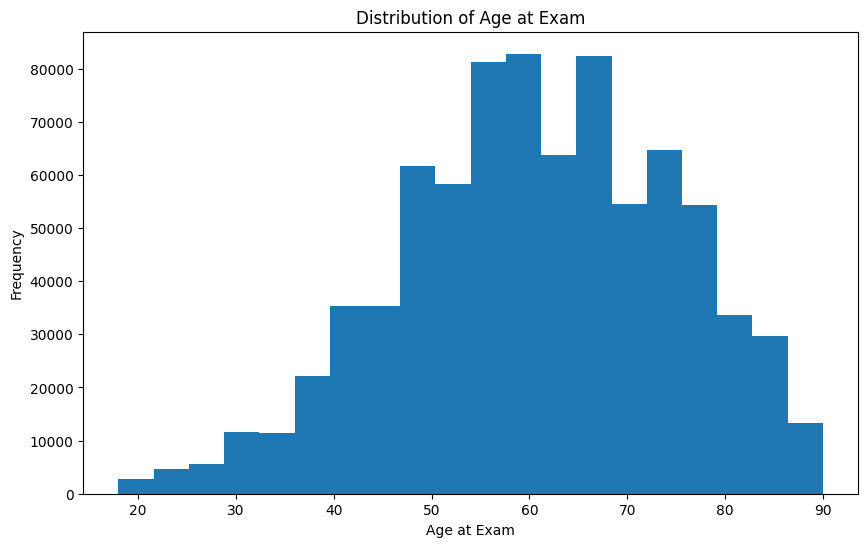

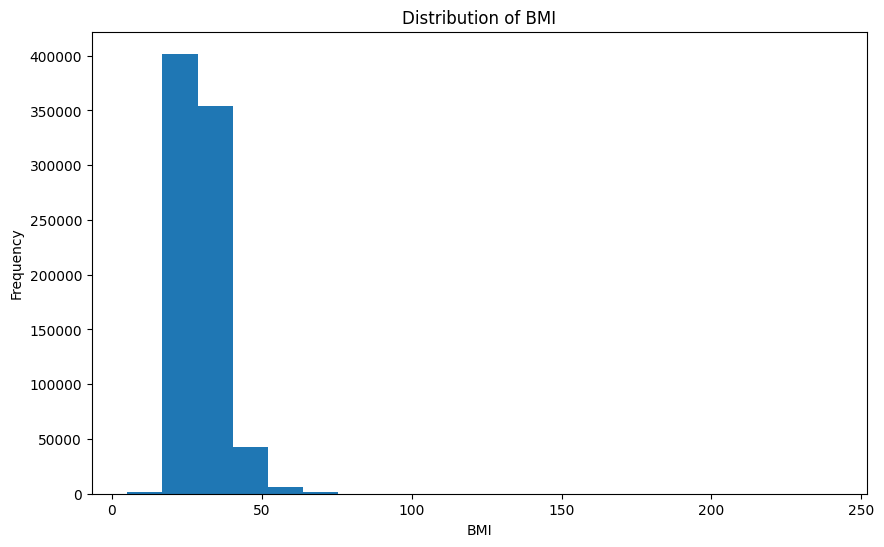

                   Minimum_Observed  Maximum_Observed  Normal_Min  Normal_Max  \
BMI                        5.080655        240.086698        10.0          80   
HDL                        0.100000          5.000000         0.1           5   
LDL                        0.100000         10.000000         0.1          10   
TG                         0.100000         57.340000         0.1          20   
Total_Cholesterol          0.760000         20.820000         1.0          15   
FBS                        2.000000         34.100000         1.0          30   
A1c                        0.530000         17.800000         3.0          20   
sBP                       40.000000        260.000000        50.0         300   

                   Min_Below_Plausible  Max_Above_Plausible  
BMI                               True                 True  
HDL                              False                False  
LDL                              False                False  
TG                    

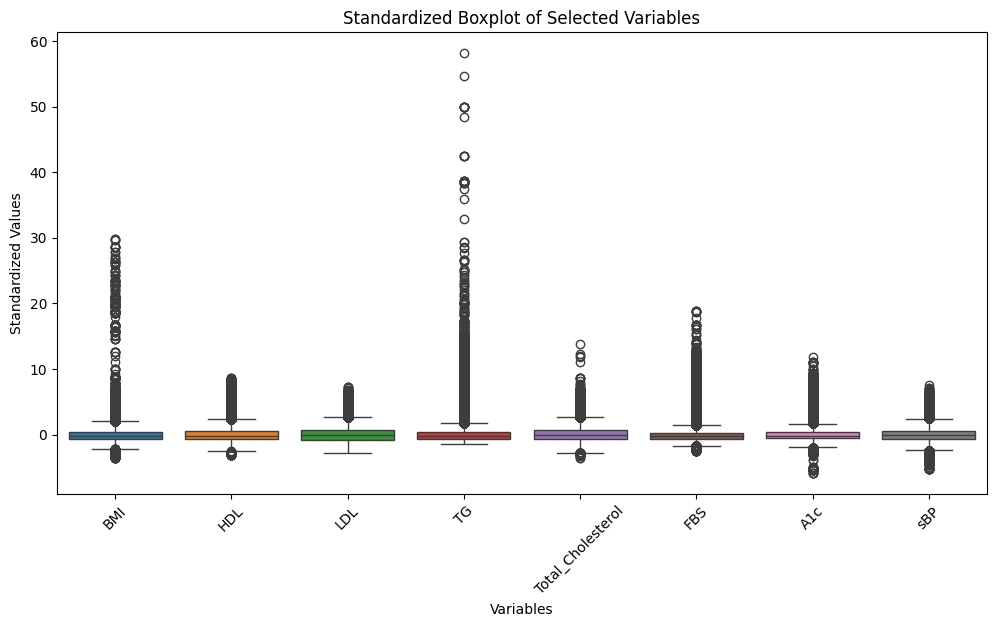

Number of missing values for Sex: 0
Depression      int64
[Anxiety)     float64
dtype: object
Depression
0    638336
1    170585
Name: count, dtype: int64
[Anxiety)
NaN    706185
0.0     68295
1.0     34441
Name: count, dtype: int64


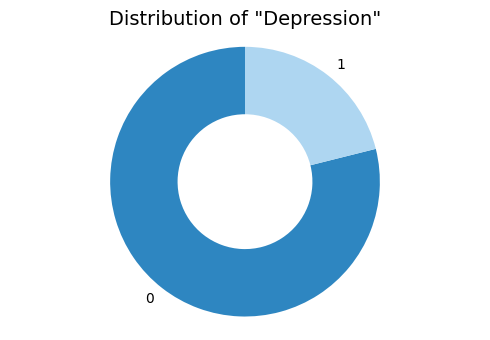

In [3]:
# Count the number of observations
num_observations = len(cpc_RAW)
print(f"Number of observations: {num_observations}")

# Count the number of duplicated observations
num_duplicates = cpc_RAW.duplicated().sum()
print(f"Number of duplicated observations: {num_duplicates}")

# Calculate the percentage of duplicated rows
percentage_duplicates = (num_duplicates / num_observations) * 100
print(f"Percentage of duplicated rows: {percentage_duplicates:.2f}%")

# List the name of all features
feature_names = cpc_RAW.columns.tolist()
print(feature_names)

# Count observations per year
year_counts = cpc_RAW['Year'].value_counts().sort_index()

# Plot observations by year
plt.figure(figsize=(10, 6))
plt.bar(year_counts.index, year_counts.values)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution of Years')
plt.show()

# Count the number of unique patient_id in the dataset
num_unique_patients = cpc_RAW['Patient_ID'].nunique()
print(f"Number of unique patients: {num_unique_patients}")

# Calculate the number of years recorded per patient
years_per_patient = cpc_RAW.groupby('Patient_ID')['Year'].nunique()

# Count how many patients fall into each "number of years followed"
years_followup_counts = years_per_patient.value_counts().sort_index()

# Plot distribution of number of years per patient
plt.figure()
plt.bar(years_followup_counts.index, years_followup_counts.values)
plt.xlabel('Number of Years')
plt.ylabel('Number of Patients')
plt.title('Distribution of Number of Years per Patient')
plt.show()

# Count how many patients have more than one record in dataset
multiple_records_count = (years_per_patient > 1).sum()
print(f"Number of patients with multiple records: {multiple_records_count}")

# Count the percentage of patients who have two or more records
percentage_multiple_records = (multiple_records_count / num_unique_patients) * 100
print(f"Percentage of patients with multiple records: {percentage_multiple_records:.2f}%")

# Calculate average number of visits per patient
average_visits = num_observations / num_unique_patients
print(f"Average number of visits per patient: {average_visits:.2f}")

# Create a histogram for Age_at_Exam variable
plt.figure(figsize=(10, 6))
plt.hist(cpc_RAW['Age_at_Exam'], bins=20)
plt.xlabel('Age at Exam')
plt.ylabel('Frequency')
plt.title('Distribution of Age at Exam')
plt.show()

# Create a histogram for BMI
plt.figure(figsize=(10, 6))
plt.hist(cpc_RAW['BMI'], bins=20)
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('Distribution of BMI')
plt.show()

# List variables that we want to investigate their biological plausibility
variables = [
    'BMI',
    'HDL',
    'LDL',
    'TG',
    'Total_Cholesterol',
    'FBS',
    'A1c',
    'sBP'
]

# Define biologically plausible limits
normal_ranges = {
    'BMI': (10, 80),
    'HDL': (0.1, 5),
    'LDL': (0.1, 10),
    'TG': (0.1, 20),
    'Total_Cholesterol': (1, 15),
    'FBS': (1, 30),
    'A1c': (3, 20),
    'sBP': (50, 300)
}

# Create summary table of observed minimum and maximum values
summary_table = pd.DataFrame({
    'Minimum_Observed': cpc_RAW[variables].min(),
    'Maximum_Observed': cpc_RAW[variables].max()
})

# Add normal range limits
summary_table['Normal_Min'] = summary_table.index.map(lambda x: normal_ranges[x][0])
summary_table['Normal_Max'] = summary_table.index.map(lambda x: normal_ranges[x][1])

# Flag whether observed min/max fall outside plausible limits
summary_table['Min_Below_Plausible'] = summary_table['Minimum_Observed'] < summary_table['Normal_Min']
summary_table['Max_Above_Plausible'] = summary_table['Maximum_Observed'] > summary_table['Normal_Max']

print(summary_table)

# Count number of implausible values for each variable
implausible_counts = {}

for var in variables:
    min_val, max_val = normal_ranges[var]
    count = (
        (cpc_RAW[var] < min_val) |
        (cpc_RAW[var] > max_val)
    ).sum()
    implausible_counts[var] = count

implausible_df = pd.DataFrame.from_dict(
    implausible_counts,
    orient='index',
    columns=['Number_of_Implausible_Values']
)

print(implausible_df)

# Standardize selected variables for visualization purposes
scaled_data = (cpc_RAW[variables] - cpc_RAW[variables].mean()) / cpc_RAW[variables].std()

# Create boxplot of standardized variables
plt.figure(figsize=(12, 6))
sns.boxplot(data=scaled_data)
plt.xticks(rotation=45)
plt.xlabel('Variables')
plt.ylabel('Standardized Values')
plt.title('Standardized Boxplot of Selected Variables')
plt.show()

# Check missing values for sex
missing_sex = cpc_RAW['Sex'].isnull().sum()
print(f"Number of missing values for Sex: {missing_sex}")

# Check variables' types
print(cpc_RAW[['Depression', '[Anxiety)']].dtypes)
counts_dep = cpc_RAW['Depression'].value_counts(dropna=False)
counts_anx = cpc_RAW['[Anxiety)'].value_counts(dropna=False)
print(counts_dep)
print(counts_anx)

# Distribution of depression
colors = ['#2E86C1', '#AED6F1', '#D5D8DC']
plt.figure(figsize=(5, 3.5))
plt.pie(
    counts_dep.values,
    labels=counts_dep.index.astype(str),
    colors=colors[:len(counts_dep)],
    startangle=90,
    wedgeprops=dict(width=0.5)
)
plt.axis('equal')
plt.title('Distribution of "Depression"', fontsize=14)
plt.tight_layout()
plt.show()


# 2. Reduce data and investigate biologically implausible records

In this section, we drop duplicated rows and keep variables we need in this project to reduce the dataset size.

Further, we will identify observations that include biologically implausible values, including:

*   BMI < 10
*   BMI > 100
*   sBP < 50
*   A1c < 3

We save the observations that include biologically implausible observations in a new dataset in addition to all other information we have on those patients to investigate reasons behind them, such as measurement error, which could inform our decisions regarding changing them into NA or imputation.

In [4]:
# Drop the duplicated rows and save it in a new data frame
cpc_REDUCED = cpc_RAW.drop_duplicates()
print(f"Number of observations after dropping duplicates: {len(cpc_REDUCED)}")


# Keep variables we need for longitudinal analysis
cpc_REDUCED = cpc_REDUCED[[
    # Identifiers
    'Patient_ID',
    'Year',
    'Sex',
    'Age_at_Exam',

    # Chronic condition binary indicators
    'HTN',
    'COPD',
    'Diabetes',
    'OA',
    'Depression',

    # Onset dates
    'HTN_OnsetDate',
    'OA_OnsetDate',
    'COPD_Date',
    'DM_OnsetDate',
    'Depression_OnsetDate',

    # Clinical measures (for plausibility checks)
    'BMI',
    'A1c',
    'FBS',
    'LDL',
    'HDL',
    'TG',
    'Total_Cholesterol',
    'sBP'
]]


# Define implausible conditions
implausible_condition = (
    (cpc_REDUCED['BMI'] < 10) |
    (cpc_REDUCED['BMI'] > 100) |
    (cpc_REDUCED['sBP'] < 50) |
    (cpc_REDUCED['A1c'] < 3)
)

# Add a flag column
cpc_REDUCED['Implausible_Flag'] = implausible_condition.astype(int)

print("Number of implausible observations:",
      cpc_REDUCED['Implausible_Flag'].sum())


# Identify patients who have at least one implausible record
implausible_patients = cpc_REDUCED.loc[
    cpc_REDUCED['Implausible_Flag'] == 1,
    'Patient_ID'
].unique()

print("Number of patients with implausible values:",
      len(implausible_patients))


# Create dataframe containing ALL records of those patients
cpc_IMPLAUSIBLE_PATIENTS_ALL_RECORDS = cpc_REDUCED[
    cpc_REDUCED['Patient_ID'].isin(implausible_patients)
].copy()

print("Total records for patients with implausible values:",
      len(cpc_IMPLAUSIBLE_PATIENTS_ALL_RECORDS))


# Sort longitudinally to inspect patterns
cpc_IMPLAUSIBLE_PATIENTS_ALL_RECORDS = \
    cpc_IMPLAUSIBLE_PATIENTS_ALL_RECORDS.sort_values(
        ['Patient_ID', 'Year']
    )


# Inspect selected columns
cpc_IMPLAUSIBLE_PATIENTS_ALL_RECORDS[
    ['Patient_ID', 'Year', 'BMI', 'A1c', 'sBP', 'Implausible_Flag']
].head(20)


# --------------------------------------------------
# Replace implausible values with NaN (do not drop rows)
# --------------------------------------------------

# Count before replacement
print("Implausible BMI values:",
      ((cpc_REDUCED['BMI'] < 10) | (cpc_REDUCED['BMI'] > 100)).sum())

print("Implausible sBP values:",
      (cpc_REDUCED['sBP'] < 50).sum())

print("Implausible A1c values:",
      (cpc_REDUCED['A1c'] < 3).sum())


# Replace with NaN
cpc_REDUCED.loc[
    (cpc_REDUCED['BMI'] < 10) | (cpc_REDUCED['BMI'] > 100),
    'BMI'
] = np.nan

cpc_REDUCED.loc[
    cpc_REDUCED['sBP'] < 50,
    'sBP'
] = np.nan

cpc_REDUCED.loc[
    cpc_REDUCED['A1c'] < 3,
    'A1c'
] = np.nan


print("Implausible values replaced with NaN.")

Number of observations after dropping duplicates: 745469
Number of implausible observations: 219
Number of patients with implausible values: 101
Total records for patients with implausible values: 636
Implausible BMI values: 176
Implausible sBP values: 12
Implausible A1c values: 31
Implausible values replaced with NaN.


# 3. Reorganize data for longitudinal analysis

In this section, we do a quality control check, where we examine if the onset date of chronic conditions recorded for one patient is identical (as it should be.)

Second, we convert the event-based dataset to patient-based data.

In [5]:
# Convert onset date variables to datetime
date_columns = [
    'HTN_OnsetDate',
    'OA_OnsetDate',
    'COPD_Date',
    'DM_OnsetDate',
    'Depression_OnsetDate'
]

for col in date_columns:
    cpc_REDUCED[col] = pd.to_datetime(cpc_REDUCED[col], errors='coerce')


# Function to check inconsistency for chronic condition onset date
def check_onset_consistency(data, onset_column):

    inconsistency = (
        data
        .groupby('Patient_ID')[onset_column]
        .nunique()
    )

    problem_patients = inconsistency[inconsistency > 1]

    print(f"{onset_column}: {len(problem_patients)} patients with inconsistent onset dates")

    return problem_patients


# Check consistency of onset date for all chronic conditions in this study
htn_problem = check_onset_consistency(cpc_REDUCED, 'HTN_OnsetDate')
oa_problem = check_onset_consistency(cpc_REDUCED, 'OA_OnsetDate')
copd_problem = check_onset_consistency(cpc_REDUCED, 'COPD_Date')
dm_problem = check_onset_consistency(cpc_REDUCED, 'DM_OnsetDate')
dep_problem = check_onset_consistency(cpc_REDUCED, 'Depression_OnsetDate')


# Sort dataset longitudinally before extracting baseline
cpc_REDUCED = cpc_REDUCED.sort_values(['Patient_ID', 'Year'])


# Extract baseline visit information (first observed record per patient)
baseline_info = (
    cpc_REDUCED
    .groupby('Patient_ID')
    .first()[[
        'Year',
        'Age_at_Exam',
        'Sex',
        'BMI',
        'A1c',
        'FBS',
        'LDL',
        'HDL',
        'TG',
        'Total_Cholesterol',
        'sBP'
    ]]
    .reset_index()
)


# Collapse onset dates and binary disease indicators to patient-level
onset_info = (
    cpc_REDUCED
    .groupby('Patient_ID')
    .agg({
        'HTN_OnsetDate': 'min',
        'OA_OnsetDate': 'min',
        'COPD_Date': 'min',
        'DM_OnsetDate': 'min',
        'Depression_OnsetDate': 'min',

        'HTN': 'max',
        'COPD': 'max',
        'Diabetes': 'max',
        'OA': 'max',
        'Depression': 'max'
    })
    .reset_index()
)


# Merge baseline information with onset information
cpc_REDUCED_p = baseline_info.merge(
    onset_info,
    on='Patient_ID',
    how='left'
)

print(f"Number of patients in patient-level dataset: {len(cpc_REDUCED_p)}")


# Create number of chronic conditions variable
cpc_REDUCED_p['Num_Chronic'] = (
    cpc_REDUCED_p[['HTN','COPD','Diabetes','OA']].sum(axis=1)
)

HTN_OnsetDate: 0 patients with inconsistent onset dates
OA_OnsetDate: 0 patients with inconsistent onset dates
COPD_Date: 0 patients with inconsistent onset dates
DM_OnsetDate: 0 patients with inconsistent onset dates
Depression_OnsetDate: 0 patients with inconsistent onset dates
Number of patients in patient-level dataset: 171619


# 4. Define cohort and depression outcome properly

In [6]:
# Convert onset date variables to datetime (ensure correct type)
date_columns = [
    'HTN_OnsetDate',
    'OA_OnsetDate',
    'COPD_Date',
    'DM_OnsetDate',
    'Depression_OnsetDate'
]

for col in date_columns:
    cpc_REDUCED_p[col] = pd.to_datetime(cpc_REDUCED_p[col], errors='coerce')


# Convert baseline year to a datetime object (January 1 of baseline year)
cpc_REDUCED_p['Baseline_Date'] = pd.to_datetime(
    cpc_REDUCED_p['Year'].astype(str) + "-01-01"
)


# Remove patients with depression prior to first visit (baseline)
cpc_REDUCED_p = cpc_REDUCED_p.loc[
    (cpc_REDUCED_p['Depression_OnsetDate'].isna()) |
    (cpc_REDUCED_p['Depression_OnsetDate'] > cpc_REDUCED_p['Baseline_Date'])
].copy()

print(f"Number of patients after removing pre-baseline depression: {len(cpc_REDUCED_p)}")


# Calculate number and percentage of people with depression
depression_counts = cpc_REDUCED_p['Depression'].value_counts().sort_index()
depression_percentage = (depression_counts / len(cpc_REDUCED_p) * 100).round(2)

depression_table = pd.DataFrame({
    'Count': depression_counts,
    'Percentage (%)': depression_percentage
})

print("Depression Distribution:")
print(depression_table)


# Create earliest chronic condition onset date
cpc_REDUCED_p['First_Chronic_Onset'] = cpc_REDUCED_p[
    ['HTN_OnsetDate', 'OA_OnsetDate', 'COPD_Date', 'DM_OnsetDate']
].min(axis=1)


# Define time zero
# If chronic onset occurs after baseline → use chronic onset
# Otherwise → use baseline
cpc_REDUCED_p['Time_Zero'] = cpc_REDUCED_p['Baseline_Date']

mask = (
    (cpc_REDUCED_p['First_Chronic_Onset'].notna()) &
    (cpc_REDUCED_p['First_Chronic_Onset'] > cpc_REDUCED_p['Baseline_Date'])
)

cpc_REDUCED_p.loc[mask, 'Time_Zero'] = \
    cpc_REDUCED_p.loc[mask, 'First_Chronic_Onset']


# Define end of 5-year follow-up window
cpc_REDUCED_p['Followup_End_5yr'] = \
    cpc_REDUCED_p['Time_Zero'] + pd.DateOffset(years=5)


# Create 5-year depression outcome
cpc_REDUCED_p['Depression_within_5yrs'] = (
    (cpc_REDUCED_p['Depression_OnsetDate'].notna()) &
    (cpc_REDUCED_p['Depression_OnsetDate'] <= cpc_REDUCED_p['Followup_End_5yr'])
).astype(int)


# Create table for 5-year depression outcome
outcome_counts = \
    cpc_REDUCED_p['Depression_within_5yrs'].value_counts().sort_index()

outcome_table = pd.DataFrame({
    'Count': outcome_counts,
    'Percentage (%)': (
        outcome_counts / outcome_counts.sum() * 100
    ).round(2)
})

outcome_table.index = [
    'No Depression (0)',
    'Depression within 5 yrs (1)'
]

print("5-Year Depression Outcome Distribution:")
print(outcome_table)


# Define exposure status at time zero
cpc_REDUCED_p['HTN_exposed'] = (
    (cpc_REDUCED_p['HTN_OnsetDate'].notna()) &
    (cpc_REDUCED_p['HTN_OnsetDate'] <= cpc_REDUCED_p['Time_Zero'])
).astype(int)

cpc_REDUCED_p['OA_exposed'] = (
    (cpc_REDUCED_p['OA_OnsetDate'].notna()) &
    (cpc_REDUCED_p['OA_OnsetDate'] <= cpc_REDUCED_p['Time_Zero'])
).astype(int)

cpc_REDUCED_p['COPD_exposed'] = (
    (cpc_REDUCED_p['COPD_Date'].notna()) &
    (cpc_REDUCED_p['COPD_Date'] <= cpc_REDUCED_p['Time_Zero'])
).astype(int)

cpc_REDUCED_p['Diabetes_exposed'] = (
    (cpc_REDUCED_p['DM_OnsetDate'].notna()) &
    (cpc_REDUCED_p['DM_OnsetDate'] <= cpc_REDUCED_p['Time_Zero'])
).astype(int)


# Create number of chronic conditions at time zero
cpc_REDUCED_p['Num_Chronic_at_TimeZero'] = \
    cpc_REDUCED_p[
        ['HTN_exposed',
         'OA_exposed',
         'COPD_exposed',
         'Diabetes_exposed']
    ].sum(axis=1)


# Create table for number of chronic conditions at time zero
chronic_counts = \
    cpc_REDUCED_p['Num_Chronic_at_TimeZero'].value_counts().sort_index()

chronic_table = pd.DataFrame({
    'Count': chronic_counts,
    'Percentage (%)': (
        chronic_counts / chronic_counts.sum() * 100
    ).round(2)
})

print("Chronic Condition Distribution at Time Zero:")
print(chronic_table)

Number of patients after removing pre-baseline depression: 158293
Depression Distribution:
             Count  Percentage (%)
Depression                        
0           139234           87.96
1            19059           12.04
5-Year Depression Outcome Distribution:
                              Count  Percentage (%)
No Depression (0)            140963           89.05
Depression within 5 yrs (1)   17330           10.95
Chronic Condition Distribution at Time Zero:
                         Count  Percentage (%)
Num_Chronic_at_TimeZero                       
0                        76555           48.36
1                        72066           45.53
2                         8354            5.28
3                         1257            0.79
4                           61            0.04


# 5. Random Forest (Model 1: Demographics + Chronic Conditions)

In this section, we run a random forrest model with:


*   70/30 split
*   5-fold cross validation
*   No leakage



In [7]:
# Define outcome
y = cpc_REDUCED_p['Depression_within_5yrs']

# Define features (Model 1: Demographics + Chronic Conditions)
features_model1 = [
    'Age_at_Exam',
    'Sex',
    'HTN_exposed',
    'OA_exposed',
    'COPD_exposed',
    'Diabetes_exposed',
    'Num_Chronic_at_TimeZero'
]

X = cpc_REDUCED_p[features_model1]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


# Encode Sex if needed
if X['Sex'].dtype == 'object':
    X['Sex'] = X['Sex'].astype('category').cat.codes


# Train-test split (70/30)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))


# Random Forest model
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

rf_model1 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])


# 5-fold cross-validation
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_model1 = cross_val_score(
    rf_model1,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc'
)

print("Model 1 - Cross-validated AUC:", cv_scores_model1.mean())


# Fit and evaluate
rf_model1.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score

y_pred_proba = rf_model1.predict_proba(X_test)[:, 1]
test_auc_model1 = roc_auc_score(y_test, y_pred_proba)

print("Model 1 - Test AUC:", test_auc_model1)

Shape of X: (158293, 7)
Shape of y: (158293,)
Training set size: 110805
Test set size: 47488


/tmp/ipython-input-58691/916684006.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex'] = X['Sex'].astype('category').cat.codes


Model 1 - Cross-validated AUC: 0.5848162984064116
Model 1 - Test AUC: 0.5895920209154795


# 6. Random Forest and Evaluation

In [8]:
# Define features (Model 2: Add Clinical Measures)
features_model2 = [
    'Age_at_Exam',
    'Sex',
    'HTN_exposed',
    'OA_exposed',
    'COPD_exposed',
    'Diabetes_exposed',
    'Num_Chronic_at_TimeZero',
    'BMI',
    'LDL',
    'HDL',
    'TG',
    'Total_Cholesterol',
    'sBP'
]

X = cpc_REDUCED_p[features_model2]

print("Shape of X:", X.shape)


# Encode Sex if needed
if X['Sex'].dtype == 'object':
    X['Sex'] = X['Sex'].astype('category').cat.codes


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)


# Random Forest model
rf_model2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])


# 5-fold cross-validation
cv_scores_model2 = cross_val_score(
    rf_model2,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc'
)

print("Model 2 - Cross-validated AUC:", cv_scores_model2.mean())


# Fit and evaluate
rf_model2.fit(X_train, y_train)

y_pred_proba = rf_model2.predict_proba(X_test)[:, 1]
test_auc_model2 = roc_auc_score(y_test, y_pred_proba)

print("Model 2 - Test AUC:", test_auc_model2)

Shape of X: (158293, 13)


/tmp/ipython-input-58691/1119263110.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex'] = X['Sex'].astype('category').cat.codes


Model 2 - Cross-validated AUC: 0.5890401712923163
Model 2 - Test AUC: 0.5902035654779316


In [14]:
# --------------------------------------------------
# Import SMOTE tools
# --------------------------------------------------

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score


# --------------------------------------------------
# Build Model 1 with SMOTE
# --------------------------------------------------

rf_model1 = Pipeline(steps=[
    ('preprocessor', preprocessor_m1),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])


# Cross-validation (Model 1 with SMOTE)
cv_scores_m1 = cross_val_score(
    rf_model1,
    X_train_full[features_model1],
    y_train,
    cv=cv,
    scoring='roc_auc'
)

print("Model 1 (SMOTE) - Mean CV ROC-AUC:", cv_scores_m1.mean())


# Fit Model 1
rf_model1.fit(X_train_full[features_model1], y_train)


# --------------------------------------------------
# Build Model 2 with SMOTE
# --------------------------------------------------

rf_model2 = Pipeline(steps=[
    ('preprocessor', preprocessor_m2),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])


# Cross-validation (Model 2 with SMOTE)
cv_scores_m2 = cross_val_score(
    rf_model2,
    X_train_full[features_model2],
    y_train,
    cv=cv,
    scoring='roc_auc'
)

print("Model 2 (SMOTE) - Mean CV ROC-AUC:", cv_scores_m2.mean())


# Fit Model 2
rf_model2.fit(X_train_full[features_model2], y_train)


# --------------------------------------------------
# Evaluate Model 1
# --------------------------------------------------

print("\nEvaluating Model 1 (SMOTE)")

y_pred_proba_m1 = rf_model1.predict_proba(
    X_test_full[features_model1]
)[:, 1]

y_pred_m1 = (y_pred_proba_m1 >= 0.5).astype(int)

auc_m1 = roc_auc_score(y_test, y_pred_proba_m1)
pr_auc_m1 = average_precision_score(y_test, y_pred_proba_m1)
f1_m1 = f1_score(y_test, y_pred_m1)

print("Model 1 - Test ROC-AUC:", auc_m1)
print("Model 1 - Test PR-AUC:", pr_auc_m1)
print("Model 1 - Test F1-score:", f1_m1)

cm_m1 = confusion_matrix(y_test, y_pred_m1)
print("Confusion Matrix:")
print(cm_m1)


# --------------------------------------------------
# Evaluate Model 2
# --------------------------------------------------

print("\nEvaluating Model 2 (SMOTE)")

y_pred_proba_m2 = rf_model2.predict_proba(
    X_test_full[features_model2]
)[:, 1]

y_pred_m2 = (y_pred_proba_m2 >= 0.5).astype(int)

auc_m2 = roc_auc_score(y_test, y_pred_proba_m2)
pr_auc_m2 = average_precision_score(y_test, y_pred_proba_m2)
f1_m2 = f1_score(y_test, y_pred_m2)

print("Model 2 - Test ROC-AUC:", auc_m2)
print("Model 2 - Test PR-AUC:", pr_auc_m2)
print("Model 2 - Test F1-score:", f1_m2)

cm_m2 = confusion_matrix(y_test, y_pred_m2)
print("Confusion Matrix:")
print(cm_m2)


# --------------------------------------------------
# Comparison Table
# --------------------------------------------------

comparison_table = pd.DataFrame({
    'Model': ['Model 1 (SMOTE)', 'Model 2 (SMOTE)'],
    'CV ROC-AUC': [cv_scores_m1.mean(), cv_scores_m2.mean()],
    'Test ROC-AUC': [auc_m1, auc_m2],
    'Test PR-AUC': [pr_auc_m1, pr_auc_m2],
    'Test F1-score': [f1_m1, f1_m2]
})

print("\nModel Comparison Summary:")
print(comparison_table)

Model 1 (SMOTE) - Mean CV ROC-AUC: 0.5787427156117662
Model 2 (SMOTE) - Mean CV ROC-AUC: 0.5702054155015548

Evaluating Model 1 (SMOTE)
Model 1 - Test ROC-AUC: 0.5905012815148056
Model 1 - Test PR-AUC: 0.14932160207879583
Model 1 - Test F1-score: 0.22087649402390439
Confusion Matrix:
[[25160 17129]
 [ 2427  2772]]

Evaluating Model 2 (SMOTE)
Model 2 - Test ROC-AUC: 0.5708722472677232
Model 2 - Test PR-AUC: 0.13404787563905365
Model 2 - Test F1-score: 0.07504745218280041
Confusion Matrix:
[[40896  1393]
 [ 4942   257]]

Model Comparison Summary:
             Model  CV ROC-AUC  Test ROC-AUC  Test PR-AUC  Test F1-score
0  Model 1 (SMOTE)    0.578743      0.590501     0.149322       0.220876
1  Model 2 (SMOTE)    0.570205      0.570872     0.134048       0.075047


Top 15 Feature Importances (Model 2):
                      Feature  Importance
0                 Age_at_Exam    0.103171
1                  Sex_Female    0.091068
2                    Sex_Male    0.090392
3                         BMI    0.089916
4                         sBP    0.081919
5                          TG    0.081415
6                         HDL    0.077576
7                         LDL    0.072982
8           Total_Cholesterol    0.072212
9   Num_Chronic_at_TimeZero_1    0.040363
10  Num_Chronic_at_TimeZero_0    0.031867
11              HTN_exposed_1    0.028822
12              HTN_exposed_0    0.027305
13               OA_exposed_1    0.024063
14               OA_exposed_0    0.021930


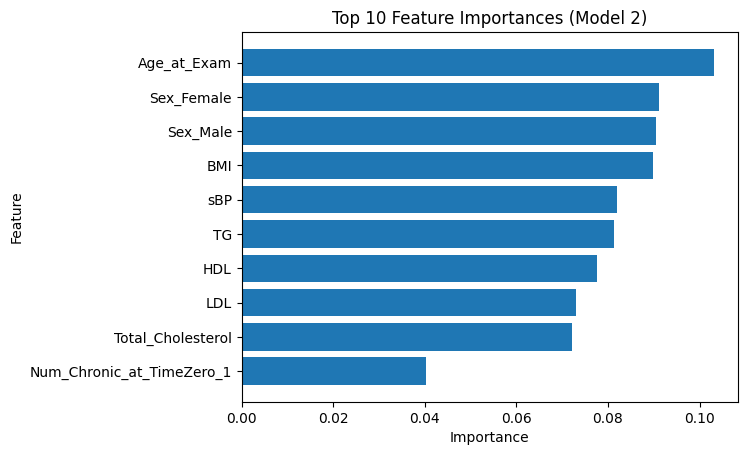

In [15]:
# --------------------------------------------------
# Feature Importance (Model 2 with SMOTE)
# --------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt

# Extract trained Random Forest model
rf = rf_model2.named_steps['rf']

# Get transformed feature names after preprocessing
feature_names = rf_model2.named_steps['preprocessor'] \
    .get_feature_names_out()

# Extract importance values
importances = rf.feature_importances_

# Create feature importance table
feature_importance_table = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Clean feature names for readability
feature_importance_table['Feature'] = \
    feature_importance_table['Feature'] \
    .str.replace('num__', '', regex=False) \
    .str.replace('cat__', '', regex=False)

# Sort descending
feature_importance_table = feature_importance_table \
    .sort_values(by='Importance', ascending=False) \
    .reset_index(drop=True)

print("Top 15 Feature Importances (Model 2):")
print(feature_importance_table.head(15))


# --------------------------------------------------
# Plot Top 10 Features
# --------------------------------------------------

top10 = feature_importance_table.head(10)

plt.figure()
plt.barh(top10['Feature'], top10['Importance'])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Model 2)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Confusion Matrix:
[[42286     3]
 [ 5197     2]]

True Negatives: 42286
False Positives: 3
False Negatives: 5197
True Positives: 2

Sensitivity: 0.0004
Specificity: 0.9999


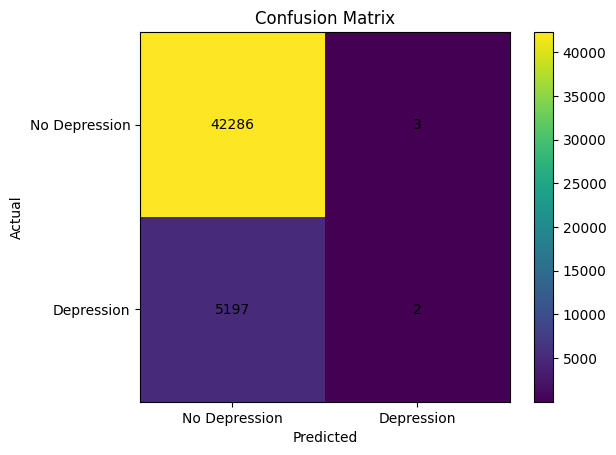

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


# --------------------------------------------------
# Generate predictions (Model 2 example)
# --------------------------------------------------

y_pred_proba = rf_model2.predict_proba(
    X_test_full[features_model2]
)[:, 1]

# Default threshold = 0.5
y_pred = (y_pred_proba >= 0.5).astype(int)


# --------------------------------------------------
# Confusion Matrix
# --------------------------------------------------

cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)


# Extract TN, FP, FN, TP
tn, fp, fn, tp = cm.ravel()

print("\nTrue Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)


# --------------------------------------------------
# Sensitivity and Specificity
# --------------------------------------------------

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("\nSensitivity:", round(sensitivity, 4))
print("Specificity:", round(specificity, 4))


# --------------------------------------------------
# Plot Confusion Matrix
# --------------------------------------------------

plt.figure()

plt.imshow(cm)
plt.colorbar()

plt.xticks([0, 1], ['No Depression', 'Depression'])
plt.yticks([0, 1], ['No Depression', 'Depression'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Add text annotations
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center")

plt.show()